### **Random Forests** 

Random Forest is a **bagging** technique that **trains multiple decision trees** with **minor modification** in split criterion.

![](Images/rf_dt.png)

In case of decision trees, we train a single decision tree. 

In random forest we train multiple decision trees on different training sets obtained through bagging (aka Boostrap Agreggation).

### **Algorithm**
**Input**:

1. The training data $D$ with shape $(n,m)$, say $D_1,D_2,\ldots ,D_q$ with replacement from $D$.

2. In each of the datasets $D_j$, select $u$ out of $m$ where $u \le m$ features before each split and train a full decision tree $h_j(\mathbf x)$

3. The final predictor : 

  * For regression, an average output from $q$ regressors is assigned to the new example:
  
  $$ h(\mathbf x) = \frac {1}{q} \sum_{j=1}^q h_j(\mathbf x) $$

  * For classification, a majority voting is taken and the class label with the maximum number of votes is assigned to the new example.

### **Implementation**

In order to keep the implementation focussed to main components of random forest, we make use of `DecisionTreeClassifier` from scikit-learn library for the decision tree components.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.tree import DecisionTreeClassifier

We will build the code component-wise and finally combine them into a `RandomForest` class.

#### **Bagging**

We define a function for bagging - creating boostrap samples $D_1,D_2,\ldots,D_q$ from the original dataset $D:$

The **key step** is : 

`np.random.choice` with **size=n_samples** and **replace=True** 

It ensures that the boostrapped sample has the same number of samples as the original dataset and it is obtained by sampling with replacement.

In [2]:
def bag(X, y):
    # Counts the number or rows in the feature matrix
    n_samples = X.shape[0]

    # Generates a random sample from the  given input.
    indices = np.random.choice(n_samples, size=n_samples, replace=True, random_state=1)

    # Note that the second argument size has been set to the size of the original sample dataset and replacement has been set to True

    return X[indices], y[indices]

#### **Majority Voting**
Code `up` `most_common_label` function for obtaining majority vote for  class labels.

In [3]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [4]:
y = [1, 1, 1, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3]

print(Counter(y))
print(Counter(y).most_common(2)[0][0])

Counter({3: 5, 2: 4, 1: 3, 0: 2})
3


### **Random forest class**

We create a `RandomForest` class with the following default parameters :

* number of trees = 10

* minimum number of samples = 2

* maximum depth = 100 

The `max_features` is a configurable parameter that can be set by the user.

In [5]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, max_features=None):
        # hyperparameter for fixing number of trees to be generated
        self.n_trees = n_trees  

        # min no of samples required for split
        self.min_samples_split = min_samples_split

        # maximum depth of decision tree
        self.max_depth = max_depth 

        # maximum no of features to be considered
        self.max_features = max_features  
        self.trees = []

### **Training Random Forest**
We implement the `fit` method.

* Initialize an empty list of decision tree classifiers.

* In the `for` loop, we train each decision tree with parameters set from random forest on a boostrapped sample obtained through the `bag` function.

In [6]:
def fit(self, X, y):
    # Empty array of trees which gets filled in during operations.
    self.trees = []

    # we are using underscore we are just repeating the operations.
    for _ in range(self.n_trees):
        tree = DecisionTreeClassifier(
            min_samples_split=self.min_samples_split,
            max_depth=self.max_depth,
            max_features=self.max_features)

    X_sample, y_sample = bag(X, y)
    tree.fit(X_sample, y_sample)
    # we will append each of these tree.
    self.trees.append(tree)  

### **Inference**
Let's implement `predict` function : 

Here, we need to note that each of the trees will give predictions for all the individual rows of the input data.

**For example :** If we have a random forest with 3 trees and 2 classes 0 & 1, let's assume the prediciton for 5 samples is as follows : 

* Tree 1 gives 00111

* Tree 2 gives 11001

* Tree 3 gives 10101

We need to aggregate the output for the respective samples and take an average / majority vote. For this, we will use `np.swapaxes`.

In [7]:
def predict(self, X):
    tree_predict = np.array([tree.predict(X) for tree in self.trees])

    # each of the trees will give out predictions
    tree_predict = np.swapaxes(tree_predict, 0, 1)

    y_pred = [most_common_label(tree_pred) for tree_pred in tree_predict]
    return np.array(y_pred)

### **Combined all Components**

In [8]:
def bag(X, y):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[indices], y[indices]


def most_common_label(y):
  counter = Counter(y)
  most_common = counter.most_common(1)[0][0]
  return most_common


class RandomForest:
  def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, max_features=None):
    self.n_trees = n_trees  
    self.min_samples_split = min_samples_split
    self.max_depth = max_depth  
    self.max_features = max_features 
    self.trees = []

  def fit(self, X, y):
    self.trees = []

    for _ in range(self.n_trees):
      tree = DecisionTreeClassifier(  
          min_samples_split=self.min_samples_split,
          max_depth=self.max_depth,
          max_features=self.max_features)

      X_sample, y_sample = bag(X, y)
      tree.fit(X_sample, y_sample)
      self.trees.append(tree)  

  def predict(self, X):
    tree_predict = np.array([tree.predict(X) for tree in self.trees])
    tree_predict = np.swapaxes(tree_predict, 0, 1)

    y_pred = [most_common_label(tree_pred) for tree_pred in tree_predict]
    return np.array(y_pred)

### **Demonstration**

Let us demonstrate our implementation of Random Forest on a real world dataset.

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred)/len(y_true)
    return accuracy

In [10]:
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [11]:
clf = RandomForest(n_trees=10, max_depth=10, max_features='sqrt')
clf.fit(X_train, y_train)

In [12]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)


Accuracy: 0.9473684210526315


Let us look at the confusion matrix and classification report on the test set.

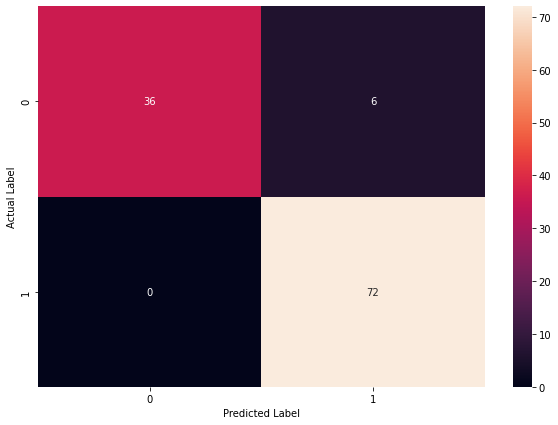

In [13]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [14]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        42
           1       0.92      1.00      0.96        72

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114

